In [ ]:
from collections import Counter, defaultdict
from itertools import combinations
import pandas as pd
import numpy as np
import operator
import math
import itertools
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing, tree
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid

2023-12-04 23:54:46.766062: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 23:54:47.081859: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 23:54:47.126154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-04 23:54:47.126184: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

# Loading datasets

### Target Variable: fruits, crop yield lost (no longer %)

In [ ]:
# target
fruits = pd.read_csv("Raw Data/fruit.csv")
fruits['Category'] = 'fruits'
#fruits = fruits.groupby(["year", "commodity"]).mean().reset_index()
fruits

,m49_code,country,region,cpc_code,commodity,year,loss_percentage,loss_percentage_original,loss_quantity,activity,food_supply_stage,treatment,cause_of_loss,sample_size,method_data_collection,reference,url,notes,Category
0,840,United States of America,NaN,1234.00,Tomatoes,2019,15.0000,15,NaN,NaN,Whole supply chain,NaN,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,fruits
1,840,United States of America,NaN,1321.00,Pomelos and grapefruits,2019,3.0000,3,NaN,NaN,Whole supply chain,NaN,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,fruits
2,840,United States of America,NaN,1321.00,Pomelos and grapefruits,2019,3.0000,3,NaN,NaN,Whole supply chain,NaN,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,fruits
3,840,United States of America,NaN,1322.00,Lemons and limes,2019,4.0000,4,NaN,NaN,Whole supply chain,NaN,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,fruits
4,840,United States of America,NaN,1322.00,Lemons and limes,2019,5.0000,5,NaN,NaN,Whole supply chain,NaN,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,fruits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,840,United States of America,NaN,1355.02,Cranberries,2000,4.0000,4,NaN,NaN,Whole supply chain,NaN,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,fruits
650,840,United States of America,NaN,21431.01,Orange juice,2000,40.8538,40.8538,NaN,NaN,Whole supply chain,NaN,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,fruits
651,840,United States of America,NaN,21432.00,Grapefruit juice,2000,43.7016,43.7016,NaN,NaN,Whole supply chain,NaN,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,fruits
652,840,United States of America,NaN,21434.00,Grape juice,2000,19.0909,19.0909,NaN,NaN,Whole supply chain,NaN,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,fruits


In [ ]:
foodYield = pd.read_csv("Raw Data/FoodYield.csv")
foodYield.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,840,United States of America,5419,Yield,1371.0,"Almonds, in shell",2000,2000,100 g/ha,26342,A,Official figure,NaN
1,QCL,Crops and livestock products,840,United States of America,5419,Yield,1371.0,"Almonds, in shell",2001,2001,100 g/ha,28402,A,Official figure,NaN
2,QCL,Crops and livestock products,840,United States of America,5419,Yield,1371.0,"Almonds, in shell",2002,2002,100 g/ha,36275,A,Official figure,NaN
3,QCL,Crops and livestock products,840,United States of America,5419,Yield,1371.0,"Almonds, in shell",2003,2003,100 g/ha,35325,A,Official figure,NaN
4,QCL,Crops and livestock products,840,United States of America,5419,Yield,1371.0,"Almonds, in shell",2004,2004,100 g/ha,34074,A,Official figure,NaN


### Features: co2, fertilizers, food insec, food prod, gdp, land usage, precipitation, rail access, rural, temp -- based on FAO Official Indicators page for USA

In [ ]:
co2 = pd.read_csv("Raw Data/CO2 Emissions.csv")
co2 = co2.loc[(co2['Year'] >= 2000) & (co2['Year'] <= 2019)]
co2

,Year,CO2 Emissions
10,2000,20.469797
11,2001,20.171537
12,2002,19.445530
13,2003,19.506506
14,2004,19.597617
15,2005,19.469273
16,2006,18.945917
17,2007,19.042912
18,2008,18.278491
19,2009,16.808681


In [ ]:
fertilizers = pd.read_csv("Raw Data/Fertilizers.csv")
fertilizers = fertilizers[['Year', 'Item', 'Value']]
fertilizers = fertilizers.loc[(fertilizers['Year'] >= 2000) & (fertilizers['Year'] <= 2019)]
fertilizers = fertilizers.pivot(index='Year', columns='Item')['Value'].reset_index()
fertilizers

Item,Year,Nutrient nitrogen N (total),Nutrient phosphate P2O5 (total),Nutrient potash K2O (total)
0,2000,10703440.99,3882645.38,4485439.54
1,2001,10752682.57,4065027.67,4499138.17
2,2002,10969768.11,3892275.96,4490927.14
3,2003,11818620.83,4376712.59,5007750.26
4,2004,11191484.05,4207522.64,4693229.33
5,2005,10925951.09,4062917.40,4284542.62
6,2006,11969757.81,4147376.29,4656851.22
7,2007,11395419.17,3852722.70,4227208.55
8,2008,10397606.72,2846292.00,2794582.47
9,2009,11097590.44,3775158.41,4045862.33


In [ ]:
gdp = pd.read_csv("Raw Data/GDP.csv")
gdp = gdp.loc[(gdp['Year'] >= 2000) & (gdp['Year'] <= 2019)]
gdp = gdp[['Year', 'Value']]
gdp = gdp.rename(columns={'Value':'GDP'})
gdp

,Year,GDP
0,2000,50175.7
1,2001,50155.7
2,2002,50535.3
3,2003,51503.8
4,2004,52995.2
5,2005,54338.0
6,2006,55314.2
7,2007,55892.2
8,2008,55433.7
9,2009,53521.2


In [ ]:
land_usage = pd.read_csv("Raw Data/Crop Land.csv")
land_usage = land_usage.rename(columns={'Year 1/':'Year'})
land_usage['Year'] = land_usage['Year'].astype(str).astype(int)
land_usage = land_usage.loc[(land_usage['Year'] >= 2000) & (land_usage['Year'] <= 2019)]
land_usage

,Year,Total crops harvested (million acres),Double cropped (million acres),Cropland harvested (million acres),Crop failure (million acres),Cultivated summer fallow (million acres),Total cropland used for crops (million acres)
10,2000,325,11,314,11,20,345
11,2001,321,10,311,10,19,340
12,2002,316,9,307,17,16,340
13,2003,324,8,316,10,16,342
14,2004,321,9,312,9,15,336
15,2005,321,7,314,7,16,336
16,2006,312,9,303,11,15,330
17,2007,322,10,312,8,15,335
18,2008,327,12,315,9,14,337
19,2009,319,10,310,8,15,333


In [ ]:
precipitation = pd.read_csv("Raw Data/Precipitation.csv")
precipitation = precipitation.loc[(precipitation['Year'] >= 2000) & (precipitation['Year'] <= 2019)]
precipitation

,Year,Avg. Precipitation (inches)
10,2000,28.2
11,2001,29.0
12,2002,29.1
13,2003,30.5
14,2004,33.3
15,2005,30.1
16,2006,29.8
17,2007,29.2
18,2008,31.2
19,2009,32.3


In [ ]:
rail_access = pd.read_csv("Raw Data/Rail Access.csv")
rail_access = rail_access.loc[(rail_access['Year'] >= 2000) & (rail_access['Year'] <= 2019)]
rail_access = rail_access[['Year', 'Value']]
rail_access = rail_access.rename(columns={'Value':'Rail lines density (total route in km per 100 square km of land area)'})
rail_access 

,Year,Rail lines density (total route in km per 100 square km of land area)
0,2000,2.0
1,2001,2.0
2,2002,2.1
3,2003,2.0
4,2004,2.0
5,2005,2.0
6,2006,2.0
7,2007,2.0
8,2008,2.0
9,2009,2.0


In [ ]:
rural_vs_urban = pd.read_csv("Raw Data/Rural.csv")
rural_vs_urban = rural_vs_urban[['Year', 'Element', 'Value']]
rural_vs_urban = rural_vs_urban.loc[(rural_vs_urban['Year'] >= 2000) & (rural_vs_urban['Year'] <= 2019)]
rural_vs_urban = rural_vs_urban.pivot(index='Year', columns='Element')['Value'].reset_index()
rural_vs_urban

Element,Year,Rural population,Urban population
0,2000,59054.865,222927.913
1,2001,59153.827,225698.564
2,2002,59200.835,228306.012
3,2003,59214.430,230813.194
4,2004,59219.920,233319.404
5,2005,59237.094,235892.407
6,2006,59269.355,238558.001
7,2007,59309.491,241285.684
8,2008,59345.012,244029.055
9,2009,59361.054,246715.308


In [ ]:
temperature = pd.read_csv("Raw Data/Temperature.csv")
temperature = temperature.loc[(temperature['Year'] >= 2000) & (temperature['Year'] <= 2019)]
temperature

,Year,Temperature (Farenheit)
10,2000,53.7
11,2001,53.8
12,2002,52.0
13,2003,55.0
14,2004,52.1
15,2005,53.4
16,2006,53.8
17,2007,53.8
18,2008,51.9
19,2009,52.1


In [ ]:
food_prod_var = pd.read_csv("Raw Data/Food Prod Variability.csv")
food_prod_var = food_prod_var.loc[(food_prod_var['Year'] >= 2000) & (food_prod_var['Year'] <= 2019)]
food_prod_var = food_prod_var[['Year', 'Value']]
food_prod_var = food_prod_var.rename(columns={'Value':'Per capita food production variability thousand int$ per capita'})
food_prod_var
## this ds only start in 2001, dont use for now

,Year,Per capita food production variability thousand int$ per capita
0,2001,14.4
1,2002,10.1
2,2003,20.8
3,2004,20.7
4,2005,27.1
5,2006,24.6
6,2007,27.9
7,2008,26.0
8,2009,26.1
9,2010,23.2


In [ ]:
food_supply_var = pd.read_csv("Raw Data/Food Supply Variability.csv")
food_supply_var = food_supply_var.loc[(food_supply_var['Year'] >= 2000) & (food_supply_var['Year'] <= 2019)]
food_supply_var = food_supply_var[['Year', 'Value']]
food_supply_var = food_supply_var.rename(columns={'Value':'Per capita food supply variability (kcal/cap/day)'})
food_supply_var

,Year,Per capita food supply variability (kcal/cap/day)
0,2000,26
1,2001,24
2,2002,27
3,2003,33
4,2004,34
5,2005,33
6,2006,42
7,2007,21
8,2008,25
9,2009,42


### Summary of pre-processing done

- co2: (no change needed), call on "CO2  Emissions"

- fertilizers: need to transform to "Year" as rows &  1 column for each "Nutrient nitrogen N (total)" "Nutrient phosphate P2O5 (total)" "Nutrient potash K2O (total)"

- gdp: year, value // rename value to say sth about the units & item

- land usage: same thing as fertilizers need "Year" and all item values ("Country area" "Cropland" etc")

- precipitation: (no change needed), call on "Avg. Precipitation (inches)"

- rail access: year, value // rename value to say sth about the units & item

- rural: same thing as fertilizers need "Year" and "Urban Population" "Rural Population"

- temp: (no change needed), call on "Temperature (Farenheit)"

- food prod var: year, value // rename value to say sth about the units & item

- food supply var: year, value // rename value to say sth about the units & item

- change all time scope to be 2000-2019

# Making dataset

### Target df

In [ ]:
foodYield = foodYield.rename(columns={"Value":"crop_yield"})
foodYield = foodYield[["Year", "Item", "crop_yield"]]
fruits_am = pd.merge(fruits, foodYield, how='left', left_on=['year', 'commodity'], right_on=['Year', 'Item'])
fruits_am.head()

,m49_code,country,region,cpc_code,commodity,year,loss_percentage,loss_percentage_original,loss_quantity,activity,...,cause_of_loss,sample_size,method_data_collection,reference,url,notes,Category,Year,Item,crop_yield
0,840,United States of America,NaN,1234.0,Tomatoes,2019,15.0,15,NaN,NaN,...,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,fruits,2019.0,Tomatoes,980384.0
1,840,United States of America,NaN,1321.0,Pomelos and grapefruits,2019,3.0,3,NaN,NaN,...,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,fruits,2019.0,Pomelos and grapefruits,272431.0
2,840,United States of America,NaN,1321.0,Pomelos and grapefruits,2019,3.0,3,NaN,NaN,...,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,fruits,2019.0,Pomelos and grapefruits,272431.0
3,840,United States of America,NaN,1322.0,Lemons and limes,2019,4.0,4,NaN,NaN,...,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,fruits,2019.0,Lemons and limes,398967.0
4,840,United States of America,NaN,1322.0,Lemons and limes,2019,5.0,5,NaN,NaN,...,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,fruits,2019.0,Lemons and limes,398967.0


In [ ]:
fruits_am = fruits_am[["commodity", "year", "loss_percentage", "crop_yield"]]
fruits_am["lost_crop_yield"] = (fruits_am["loss_percentage"]/100) * fruits_am["crop_yield"]
fruits_am["year"] = pd.to_datetime(fruits_am["year"].astype(str), format='%Y')
fruits_am.head()

,commodity,year,loss_percentage,crop_yield,lost_crop_yield
0,Tomatoes,2019-01-01,15.0,980384.0,147057.60
1,Pomelos and grapefruits,2019-01-01,3.0,272431.0,8172.93
2,Pomelos and grapefruits,2019-01-01,3.0,272431.0,8172.93
3,Lemons and limes,2019-01-01,4.0,398967.0,15958.68
4,Lemons and limes,2019-01-01,5.0,398967.0,19948.35


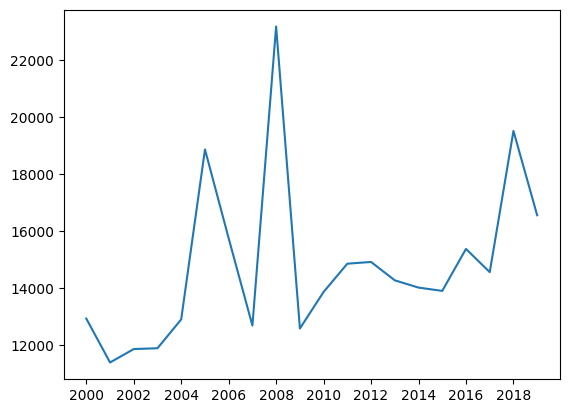

In [ ]:
f_group_am = fruits_am.groupby("year").median()[["lost_crop_yield"]] #note choice of min crop yield here
plt.plot(f_group_am)

In [ ]:
f_group_am = f_group_am.reset_index()
f_group_am = f_group_am[['year','lost_crop_yield']]
f_group_am

,year,lost_crop_yield
0,2000-01-01,12941.550
1,2001-01-01,11403.120
2,2002-01-01,11873.130
3,2003-01-01,11901.780
4,2004-01-01,12911.150
5,2005-01-01,18866.705
6,2006-01-01,15750.850
7,2007-01-01,12697.620
8,2008-01-01,23173.760
9,2009-01-01,12593.200


In [ ]:
# normalize data
scaler = MinMaxScaler(feature_range=(0,1))
f_group_am['scaled_values'] = scaler.fit_transform(f_group_am['lost_crop_yield'].values.reshape(-1,1))
f_group_am

,year,lost_crop_yield,scaled_values
0,2000-01-01,12941.550,0.130701
1,2001-01-01,11403.120,0.000000
2,2002-01-01,11873.130,0.039931
3,2003-01-01,11901.780,0.042365
4,2004-01-01,12911.150,0.128118
5,2005-01-01,18866.705,0.634085
6,2006-01-01,15750.850,0.369371
7,2007-01-01,12697.620,0.109977
8,2008-01-01,23173.760,1.000000
9,2009-01-01,12593.200,0.101106


### Features df

In [ ]:
dfs = [co2,fertilizers,gdp,land_usage,precipitation,rail_access,rural_vs_urban,temperature, food_supply_var]
from functools import reduce
#merge all DataFrames into one
features_df = reduce(lambda  left,right: pd.merge(left,right,on=['Year'],
                                            how='outer'), dfs)
features_df

,Year,CO2 Emissions,Nutrient nitrogen N (total),Nutrient phosphate P2O5 (total),Nutrient potash K2O (total),GDP,Total crops harvested (million acres),Double cropped (million acres),Cropland harvested (million acres),Crop failure (million acres),Cultivated summer fallow (million acres),Total cropland used for crops (million acres),Avg. Precipitation (inches),Rail lines density (total route in km per 100 square km of land area),Rural population,Urban population,Temperature (Farenheit),Per capita food supply variability (kcal/cap/day)
0,2000,20.469797,10703440.99,3882645.38,4485439.54,50175.7,325,11,314,11,20,345,28.2,2.0,59054.865,222927.913,53.7,26
1,2001,20.171537,10752682.57,4065027.67,4499138.17,50155.7,321,10,311,10,19,340,29.0,2.0,59153.827,225698.564,53.8,24
2,2002,19.445530,10969768.11,3892275.96,4490927.14,50535.3,316,9,307,17,16,340,29.1,2.1,59200.835,228306.012,52.0,27
3,2003,19.506506,11818620.83,4376712.59,5007750.26,51503.8,324,8,316,10,16,342,30.5,2.0,59214.430,230813.194,55.0,33
4,2004,19.597617,11191484.05,4207522.64,4693229.33,52995.2,321,9,312,9,15,336,33.3,2.0,59219.920,233319.404,52.1,34
5,2005,19.469273,10925951.09,4062917.40,4284542.62,54338.0,321,7,314,7,16,336,30.1,2.0,59237.094,235892.407,53.4,33
6,2006,18.945917,11969757.81,4147376.29,4656851.22,55314.2,312,9,303,11,15,330,29.8,2.0,59269.355,238558.001,53.8,42
7,2007,19.042912,11395419.17,3852722.70,4227208.55,55892.2,322,10,312,8,15,335,29.2,2.0,59309.491,241285.684,53.8,21
8,2008,18.278491,10397606.72,2846292.00,2794582.47,55433.7,327,12,315,9,14,337,31.2,2.0,59345.012,244029.055,51.9,25
9,2009,16.808681,11097590.44,3775158.41,4045862.33,53521.2,319,10,310,8,15,333,32.3,2.0,59361.054,246715.308,52.1,42


In [ ]:
features_df["Year"] = pd.to_datetime(features_df["Year"].astype(str), format='%Y')
features_df = features_df.rename(columns={"Year":"year"})
features_df

,year,CO2 Emissions,Nutrient nitrogen N (total),Nutrient phosphate P2O5 (total),Nutrient potash K2O (total),GDP,Total crops harvested (million acres),Double cropped (million acres),Cropland harvested (million acres),Crop failure (million acres),Cultivated summer fallow (million acres),Total cropland used for crops (million acres),Avg. Precipitation (inches),Rail lines density (total route in km per 100 square km of land area),Rural population,Urban population,Temperature (Farenheit),Per capita food supply variability (kcal/cap/day)
0,2000-01-01,20.469797,10703440.99,3882645.38,4485439.54,50175.7,325,11,314,11,20,345,28.2,2.0,59054.865,222927.913,53.7,26
1,2001-01-01,20.171537,10752682.57,4065027.67,4499138.17,50155.7,321,10,311,10,19,340,29.0,2.0,59153.827,225698.564,53.8,24
2,2002-01-01,19.445530,10969768.11,3892275.96,4490927.14,50535.3,316,9,307,17,16,340,29.1,2.1,59200.835,228306.012,52.0,27
3,2003-01-01,19.506506,11818620.83,4376712.59,5007750.26,51503.8,324,8,316,10,16,342,30.5,2.0,59214.430,230813.194,55.0,33
4,2004-01-01,19.597617,11191484.05,4207522.64,4693229.33,52995.2,321,9,312,9,15,336,33.3,2.0,59219.920,233319.404,52.1,34
5,2005-01-01,19.469273,10925951.09,4062917.40,4284542.62,54338.0,321,7,314,7,16,336,30.1,2.0,59237.094,235892.407,53.4,33
6,2006-01-01,18.945917,11969757.81,4147376.29,4656851.22,55314.2,312,9,303,11,15,330,29.8,2.0,59269.355,238558.001,53.8,42
7,2007-01-01,19.042912,11395419.17,3852722.70,4227208.55,55892.2,322,10,312,8,15,335,29.2,2.0,59309.491,241285.684,53.8,21
8,2008-01-01,18.278491,10397606.72,2846292.00,2794582.47,55433.7,327,12,315,9,14,337,31.2,2.0,59345.012,244029.055,51.9,25
9,2009-01-01,16.808681,11097590.44,3775158.41,4045862.33,53521.2,319,10,310,8,15,333,32.3,2.0,59361.054,246715.308,52.1,42


### Combine into 1 df

In [ ]:
df = pd.merge(f_group_am,features_df,on=['year'],how='outer')
df

,year,lost_crop_yield,scaled_values,CO2 Emissions,Nutrient nitrogen N (total),Nutrient phosphate P2O5 (total),Nutrient potash K2O (total),GDP,Total crops harvested (million acres),Double cropped (million acres),Cropland harvested (million acres),Crop failure (million acres),Cultivated summer fallow (million acres),Total cropland used for crops (million acres),Avg. Precipitation (inches),Rail lines density (total route in km per 100 square km of land area),Rural population,Urban population,Temperature (Farenheit),Per capita food supply variability (kcal/cap/day)
0,2000-01-01,12941.550,0.130701,20.469797,10703440.99,3882645.38,4485439.54,50175.7,325,11,314,11,20,345,28.2,2.0,59054.865,222927.913,53.7,26
1,2001-01-01,11403.120,0.000000,20.171537,10752682.57,4065027.67,4499138.17,50155.7,321,10,311,10,19,340,29.0,2.0,59153.827,225698.564,53.8,24
2,2002-01-01,11873.130,0.039931,19.445530,10969768.11,3892275.96,4490927.14,50535.3,316,9,307,17,16,340,29.1,2.1,59200.835,228306.012,52.0,27
3,2003-01-01,11901.780,0.042365,19.506506,11818620.83,4376712.59,5007750.26,51503.8,324,8,316,10,16,342,30.5,2.0,59214.430,230813.194,55.0,33
4,2004-01-01,12911.150,0.128118,19.597617,11191484.05,4207522.64,4693229.33,52995.2,321,9,312,9,15,336,33.3,2.0,59219.920,233319.404,52.1,34
5,2005-01-01,18866.705,0.634085,19.469273,10925951.09,4062917.40,4284542.62,54338.0,321,7,314,7,16,336,30.1,2.0,59237.094,235892.407,53.4,33
6,2006-01-01,15750.850,0.369371,18.945917,11969757.81,4147376.29,4656851.22,55314.2,312,9,303,11,15,330,29.8,2.0,59269.355,238558.001,53.8,42
7,2007-01-01,12697.620,0.109977,19.042912,11395419.17,3852722.70,4227208.55,55892.2,322,10,312,8,15,335,29.2,2.0,59309.491,241285.684,53.8,21
8,2008-01-01,23173.760,1.000000,18.278491,10397606.72,2846292.00,2794582.47,55433.7,327,12,315,9,14,337,31.2,2.0,59345.012,244029.055,51.9,25
9,2009-01-01,12593.200,0.101106,16.808681,11097590.44,3775158.41,4045862.33,53521.2,319,10,310,8,15,333,32.3,2.0,59361.054,246715.308,52.1,42


In [ ]:
df.columns

Index(['year', 'lost_crop_yield', 'scaled_values', 'CO2  Emissions',
       'Nutrient nitrogen N (total)', 'Nutrient phosphate P2O5 (total)',
       'Nutrient potash K2O (total)', 'GDP',
       'Total crops harvested (million acres)',
       'Double cropped (million acres)', 'Cropland harvested (million acres)',
       'Crop failure (million acres)',
       'Cultivated summer fallow (million acres)',
       'Total cropland used for crops (million acres)',
       'Avg. Precipitation (inches)',
       'Rail lines density (total route in km per 100 square km of land area)',
       'Rural population', 'Urban population', 'Temperature (Farenheit)',
       'Per capita food supply variability (kcal/cap/day)'],
      dtype='object')

# LSTM model

resources: https://pythoninoffice.com/stock-price-prediction-with-lstm-in-python/

from lab8 RNNs learnt that increase memory loss for LSTM layer is good... hmm idk what else to do

### Split into train & test (test: last 4 years aka 2016-2019)

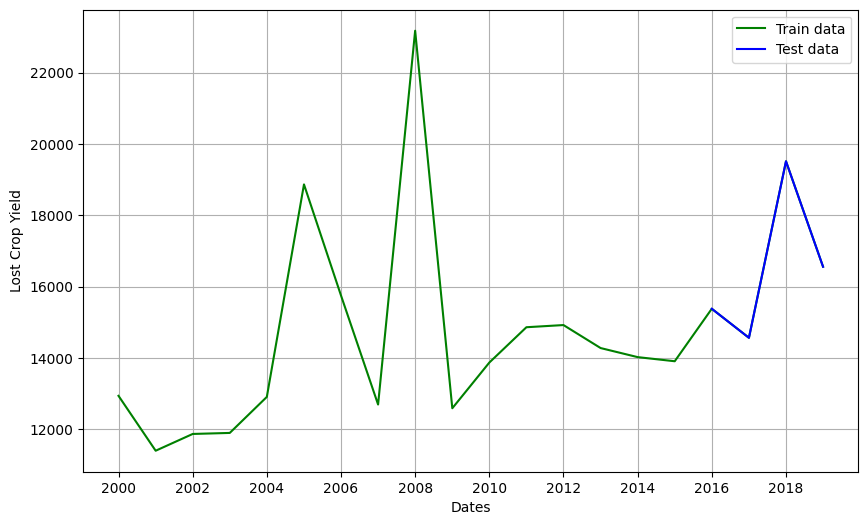

In [ ]:
# split data into train and training set
train_data = df[df['year'] < '2016-01-01']
test_data = df[df['year'] >= '2016-01-01']

# plotting the data
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Lost Crop Yield')
plt.plot(df['year'], df['lost_crop_yield'], 'green', label='Train data')
plt.plot(test_data['year'], test_data['lost_crop_yield'], 'blue', label='Test data')
plt.legend()

### Get x train, y train, x test, y test

In [ ]:
x_train = []
y_train = []

# choose 1 year as the lookback period; 2000 to predict 2001, 2001 for 2002, and so on
for i in range(1, len(train_data['scaled_values'])):
    historical_values = train_data['scaled_values'][i-1:i]
    # additional features to historical data
    additional_features = ['CO2  Emissions',
       'Nutrient nitrogen N (total)', 'Nutrient phosphate P2O5 (total)',
       'Nutrient potash K2O (total)', 'GDP',
       'Total crops harvested (million acres)',
       'Double cropped (million acres)', 'Cropland harvested (million acres)',
       'Crop failure (million acres)',
       'Cultivated summer fallow (million acres)',
       'Total cropland used for crops (million acres)',
       'Avg. Precipitation (inches)',
       'Rail lines density (total route in km per 100 square km of land area)',
       'Rural population', 'Urban population', 'Temperature (Farenheit)',
       'Per capita food supply variability (kcal/cap/day)']
    additional_feature_values = np.empty((1, len(additional_features)))
    for idx, feature_name in enumerate(additional_features): 
        # gather values for each of the features for the same lookback period
        feature_values = train_data[feature_name][i-1:i]
        additional_feature_values[:, idx] = feature_values
    # combine historical & additional features
    combined_features = np.column_stack((historical_values, additional_feature_values))
    x_train.append(combined_features)

    y_train.append(train_data['scaled_values'][i])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# converting it back to 3D array as required by LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

In [ ]:
x_test = []
y_test = test_data['scaled_values']

for i in range(1, len(test_data['scaled_values'])):
    historical_values = test_data['scaled_values'][i-1:i]
    additional_feature_values = np.empty((1, len(additional_features)))
    for idx, feature_name in enumerate(additional_features): 
        # gather values for each of the features for the same lookback period
        feature_values = test_data[feature_name][i-1:i]
        additional_feature_values[:, idx] = feature_values
    # combine historical & additional features
    combined_features = np.column_stack((historical_values, additional_feature_values))
    x_test.append(combined_features)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

### Initialize basic LSTM model

In [ ]:
!pip install keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Initialize model
model = Sequential()

# LSTM layer 1
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.25)) ## need to tune this, just use 0.25 fo rnow

# LSTM layer 2
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

# LSTM layer 3
model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# LSTM layer 3
model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# final layer
model.add(Dense(units = 1, activation ='linear'))
model.summary()

2023-12-04 23:55:08.776625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-04 23:55:08.776669: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-04 23:55:08.776694: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-342fa5dc-5dd2-4212-ac75-4267e7cc0cc3): /proc/driver/nvidia/version does not exist
2023-12-04 23:55:08.777037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Model: "sequential"
____________________________________________

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(x_train, y_train, epochs = 50, batch_size=32)

Epoch 1/50
1/1 [==============================] - 10s 10s/step - loss: 0.0643 - accuracy: 0.0667
Epoch 2/50
1/1 [==============================] - 0s 65ms/step - loss: 0.0677 - accuracy: 0.0667
Epoch 3/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0631 - accuracy: 0.0667
Epoch 4/50
1/1 [==============================] - 0s 12ms/step - loss: 0.0648 - accuracy: 0.0667
Epoch 5/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0695 - accuracy: 0.0667
Epoch 6/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0626 - accuracy: 0.0667
Epoch 7/50
1/1 [==============================] - 0s 5ms/step - loss: 0.0778 - accuracy: 0.0667
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 0.0554 - accuracy: 0.0667
Epoch 9/50
1/1 [==============================] - 0s 65ms/step - loss: 0.0550 - accuracy: 0.0667
Epoch 10/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0664 - accuracy: 0.0667
Epoch 11/50
1/1 [==================

### Prediction Results

In [ ]:
# predict on test data
predicted_fruit_loss = model.predict(x_test)
predicted_fruit_loss = scaler.inverse_transform(predicted_fruit_loss)

1/1 [==============================] - 2s 2s/step


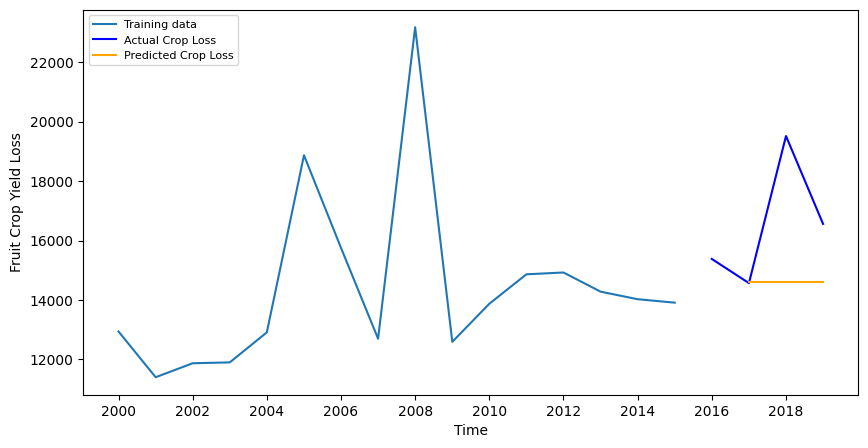

In [ ]:
# plot all the series together
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data['year'], train_data['lost_crop_yield'], label='Training data')
plt.plot(test_data['year'], test_data['lost_crop_yield'], color = 'blue', label='Actual Crop Loss')
plt.plot(test_data[1:]['year'], predicted_fruit_loss, color = 'orange',label='Predicted Crop Loss')

plt.xlabel('Time')
plt.ylabel('Fruit Crop Yield Loss')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

y_true = test_data[1:]['lost_crop_yield'].values
y_pred = predicted_fruit_loss

# report performance
mse = mean_squared_error(y_true, y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_true, y_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
print('MAPE: '+str(mape))

MSE: 9333441.748535313
MAE: 2302.3615364583334
RMSE: 3055.068206854851
MAPE: 0.12414049780735775


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=342fa5dc-5dd2-4212-ac75-4267e7cc0cc3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>